In [1]:
import pyspark
import pandas as pd

In [2]:
 from pyspark.sql.functions import avg, to_date, col, count, to_timestamp
import matplotlib.pyplot as plt

In [3]:
# Spark Session created
#from pyspark.sql import SparkSession
#spark = SparkSession.builder.getOrCreate()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("sentiment_analysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()


In [4]:
df = pd.read_csv("tweets.csv")
df.head(1)

,TweetID,UserID,Username,Timestamp,Text,State,County,City,Sentiment,COVID-related,AgeGroup,Age_Confidence,Gender,Gender_Confidence,Org_Confidence,Retweet
0,1240790697504051203,724718492205875203,lionray98,Fri Mar 20 00:02:09 +0000 2020,We learned today that two Lakers players have ...,Louisiana,NaN,NaN,0.7783,1,19-29,0.9404,male,0.9999,0.0,1


In [5]:
# Convert Pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(df)

# Show the Spark DataFrame
spark_df.show(1)

+-------------------+------------------+---------+--------------------+--------------------+---------+------+----+---------+-------------+--------+--------------+------+-----------------+--------------+-------+
|            TweetID|            UserID| Username|           Timestamp|                Text|    State|County|City|Sentiment|COVID-related|AgeGroup|Age_Confidence|Gender|Gender_Confidence|Org_Confidence|Retweet|
+-------------------+------------------+---------+--------------------+--------------------+---------+------+----+---------+-------------+--------+--------------+------+-----------------+--------------+-------+
|1240790697504051203|724718492205875203|lionray98|Fri Mar 20 00:02:...|We learned today ...|Louisiana|   NaN| NaN|   0.7783|            1|   19-29|        0.9404|  male|           0.9999|           0.0|      1|
+-------------------+------------------+---------+--------------------+--------------------+---------+------+----+---------+-------------+--------+---------

In [14]:
# Average Sentiment Score
avg_sentiment = spark_df.agg(avg(col("Sentiment"))).collect()[0][0]
print(f"Average Sentiment Score: {avg_sentiment}")

Average Sentiment Score: -0.0023534886530550744


In [15]:
# Analyze sentiment over gender
sentiment_by_gender = spark_df.groupBy("Gender") \
    .agg(avg("Sentiment").alias("avg_sentiment")) \
    .orderBy("Gender")

# Display the results
sentiment_by_gender.show()


+------+--------------------+
|Gender|       avg_sentiment|
+------+--------------------+
|   NaN|0.026613057595670668|
|female|-0.00816232093337...|
|  male|-0.00195748912825...|
+------+--------------------+



In [16]:
# 1. Sentiment vs Age and Gender
sentiment_by_age_gender = spark_df.groupBy("AgeGroup", "Gender") \
    .agg(avg("Sentiment").alias("avg_sentiment")) \
    .orderBy("AgeGroup", "Gender")

sentiment_by_age_gender.show()


+--------+------+--------------------+
|AgeGroup|Gender|       avg_sentiment|
+--------+------+--------------------+
|   19-29|female|0.012678035835790408|
|   19-29|  male|0.011412020079435087|
|   30-39|female|0.011859618693163869|
|   30-39|  male|0.015897361506065286|
|    <=18|female|9.261998996599032E-4|
|    <=18|  male|0.004968730053591849|
|    >=40|female|-0.04209821707337...|
|    >=40|  male|-0.01787842385145149|
|     NaN|   NaN|0.026613057595670668|
+--------+------+--------------------+



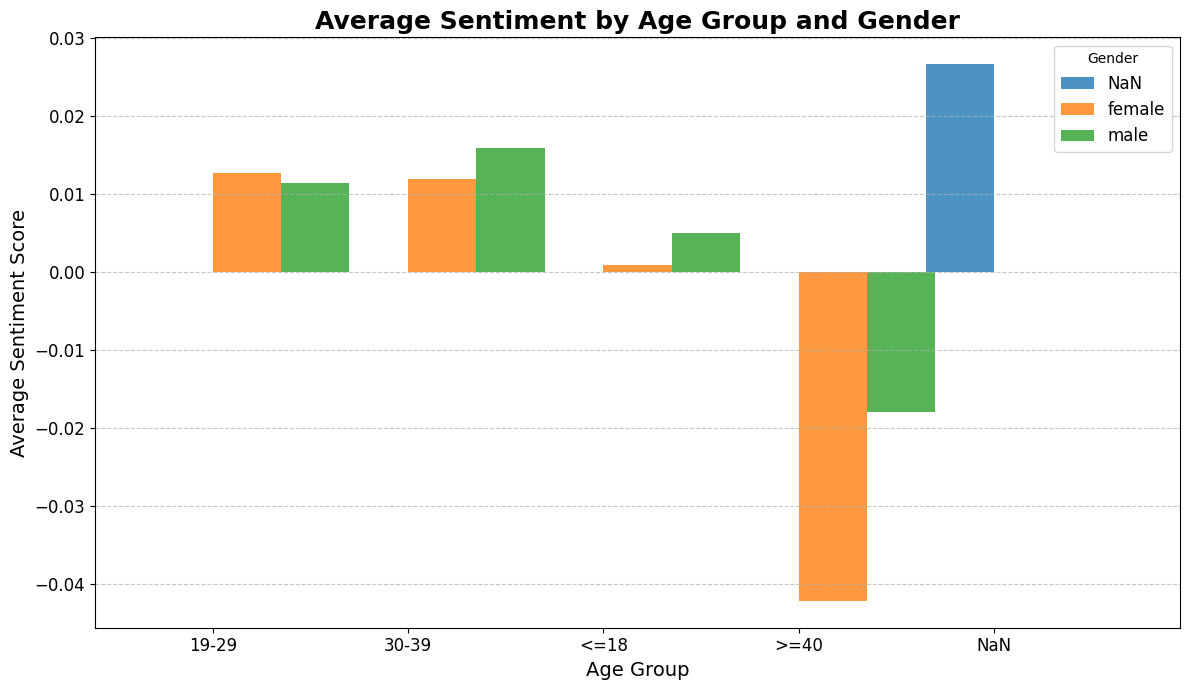

In [17]:
# 1. Sentiment vs Age and Gender
sentiment_by_age_gender = spark_df.groupBy("AgeGroup", "Gender") \
    .agg(avg("Sentiment").alias("avg_sentiment")) \
    .orderBy("AgeGroup", "Gender")

# Collect the data from the Spark DataFrame
data = sentiment_by_age_gender.collect()

# Prepare data for plotting
age_groups = sorted(set(row.AgeGroup for row in data))
genders = sorted(set(row.Gender for row in data))

# Create a matrix to hold the average sentiments
avg_sentiment_matrix = {age_group: [] for age_group in age_groups}

for age_group in age_groups:
    for gender in genders:
        # Get the average sentiment for the specific age group and gender
        row = next((row for row in data if row.AgeGroup == age_group and row.Gender == gender), None)
        if row:
            avg_sentiment_matrix[age_group].append(row.avg_sentiment)
        else:
            avg_sentiment_matrix[age_group].append(0)

# Convert the matrix into a format suitable for plotting
bar_width = 0.35
x = range(len(age_groups))

# Create the bar plot
plt.figure(figsize=(12, 7))  # Increased figure size for better clarity

# Plot bars for each gender
for i, gender in enumerate(genders):
    plt.bar([p + i * bar_width for p in x], 
            [avg_sentiment_matrix[age_group][i] for age_group in age_groups], 
            width=bar_width, 
            label=gender, 
            alpha=0.8)  # Set transparency for better visibility

# Customizing the plot
plt.title("Average Sentiment by Age Group and Gender", fontsize=18, fontweight='bold')
plt.xlabel("Age Group", fontsize=14)
plt.ylabel("Average Sentiment Score", fontsize=14)
plt.xticks([p + bar_width / 2 for p in x], age_groups, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend
plt.legend(title='Gender', fontsize=12)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

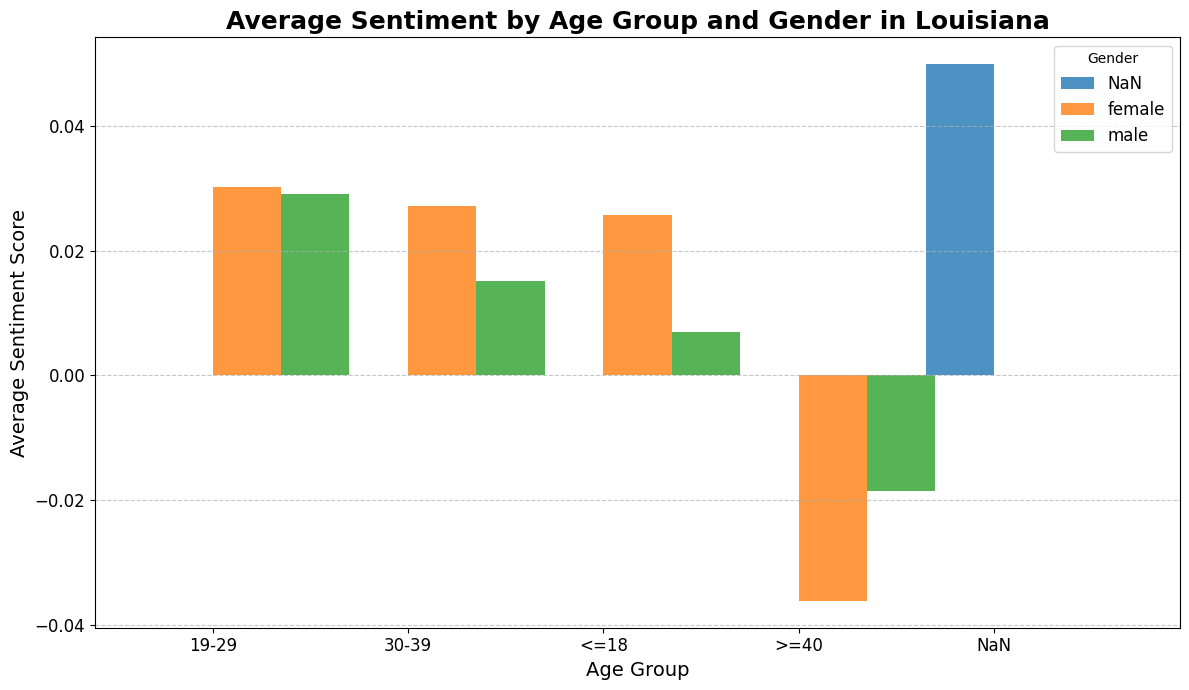

In [6]:
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt

# Assuming spark_df is your DataFrame containing sentiment data
# Filter for tweets from Louisiana
la_df = spark_df.filter(spark_df.State == 'Louisiana')

# Group by Age Group and Gender, calculate average sentiment, and sort the results
sentiment_by_age_gender = la_df.groupBy("AgeGroup", "Gender") \
    .agg(avg("Sentiment").alias("avg_sentiment")) \
    .orderBy("AgeGroup", "Gender")

# Collect the data from the Spark DataFrame
data = sentiment_by_age_gender.collect()

# Prepare data for plotting
age_groups = sorted(set(row.AgeGroup for row in data))
genders = sorted(set(row.Gender for row in data))

# Create a matrix to hold the average sentiments
avg_sentiment_matrix = {age_group: [] for age_group in age_groups}

for age_group in age_groups:
    for gender in genders:
        # Get the average sentiment for the specific age group and gender
        row = next((row for row in data if row.AgeGroup == age_group and row.Gender == gender), None)
        avg_sentiment_matrix[age_group].append(row.avg_sentiment if row else 0)

# Convert the matrix into a format suitable for plotting
bar_width = 0.35
x = range(len(age_groups))

# Create the bar plot
plt.figure(figsize=(12, 7))  # Increased figure size for better clarity

# Plot bars for each gender
for i, gender in enumerate(genders):
    plt.bar([p + i * bar_width for p in x], 
            [avg_sentiment_matrix[age_group][i] for age_group in age_groups], 
            width=bar_width, 
            label=gender, 
            alpha=0.8)  # Set transparency for better visibility

# Customizing the plot
plt.title("Average Sentiment by Age Group and Gender in Louisiana", fontsize=18, fontweight='bold')
plt.xlabel("Age Group", fontsize=14)
plt.ylabel("Average Sentiment Score", fontsize=14)
plt.xticks([p + bar_width / 2 for p in x], age_groups, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend
plt.legend(title='Gender', fontsize=12)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


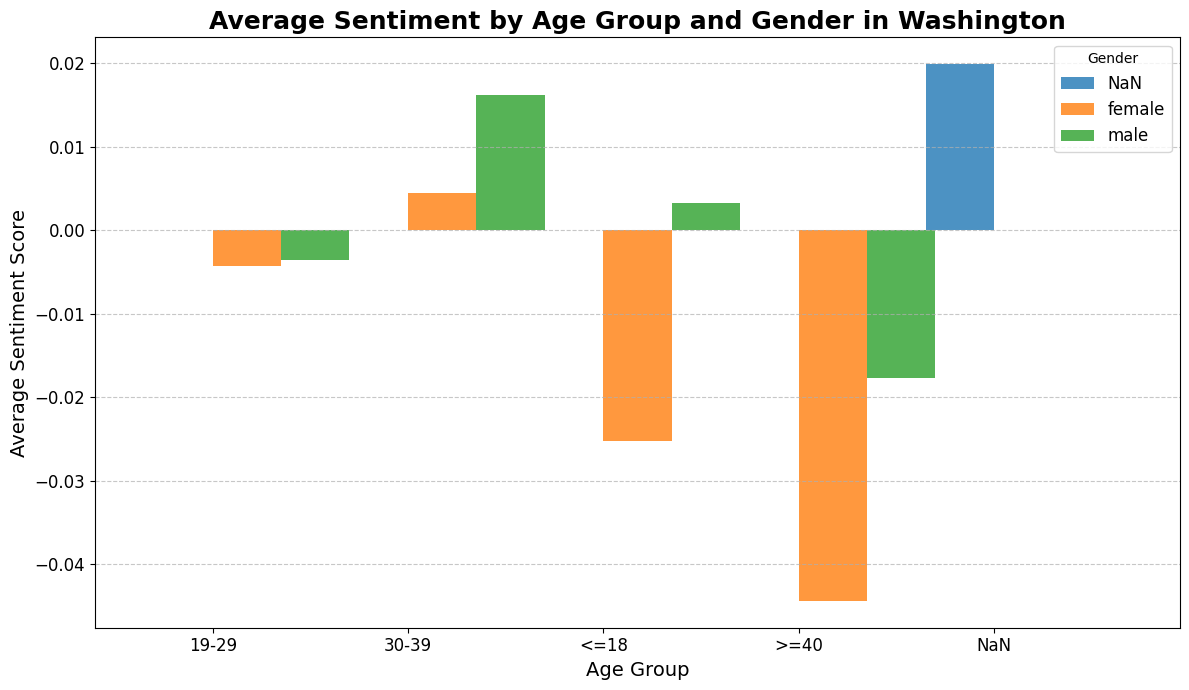

In [7]:
wa_df = spark_df.filter(spark_df.State == 'Washington')

# Group by Age Group and Gender, calculate average sentiment, and sort the results
sentiment_by_age_gender = wa_df.groupBy("AgeGroup", "Gender") \
    .agg(avg("Sentiment").alias("avg_sentiment")) \
    .orderBy("AgeGroup", "Gender")

# Collect the data from the Spark DataFrame
data = sentiment_by_age_gender.collect()

# Prepare data for plotting
age_groups = sorted(set(row.AgeGroup for row in data))
genders = sorted(set(row.Gender for row in data))

# Create a matrix to hold the average sentiments
avg_sentiment_matrix = {age_group: [] for age_group in age_groups}

for age_group in age_groups:
    for gender in genders:
        # Get the average sentiment for the specific age group and gender
        row = next((row for row in data if row.AgeGroup == age_group and row.Gender == gender), None)
        avg_sentiment_matrix[age_group].append(row.avg_sentiment if row else 0)

# Convert the matrix into a format suitable for plotting
bar_width = 0.35
x = range(len(age_groups))

# Create the bar plot
plt.figure(figsize=(12, 7))  # Increased figure size for better clarity

# Plot bars for each gender
for i, gender in enumerate(genders):
    plt.bar([p + i * bar_width for p in x], 
            [avg_sentiment_matrix[age_group][i] for age_group in age_groups], 
            width=bar_width, 
            label=gender, 
            alpha=0.8)  # Set transparency for better visibility

# Customizing the plot
plt.title("Average Sentiment by Age Group and Gender in Washington", fontsize=18, fontweight='bold')
plt.xlabel("Age Group", fontsize=14)
plt.ylabel("Average Sentiment Score", fontsize=14)
plt.xticks([p + bar_width / 2 for p in x], age_groups, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend
plt.legend(title='Gender', fontsize=12)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

+-------------------+------------------+------------+-------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+------+----+---------+-------------+--------+--------------+------+-----------------+--------------+-------+
|TweetID            |UserID            |Username    |Timestamp          |Text                                                                                                                                                                                                                                                                                 |State    |County|City|Sentiment|COVID-related|AgeGroup|Age_Confidence|Gender|Gender_Confidence|Org_Confidence|Retweet|
+-------------------+------------------+------------+-------

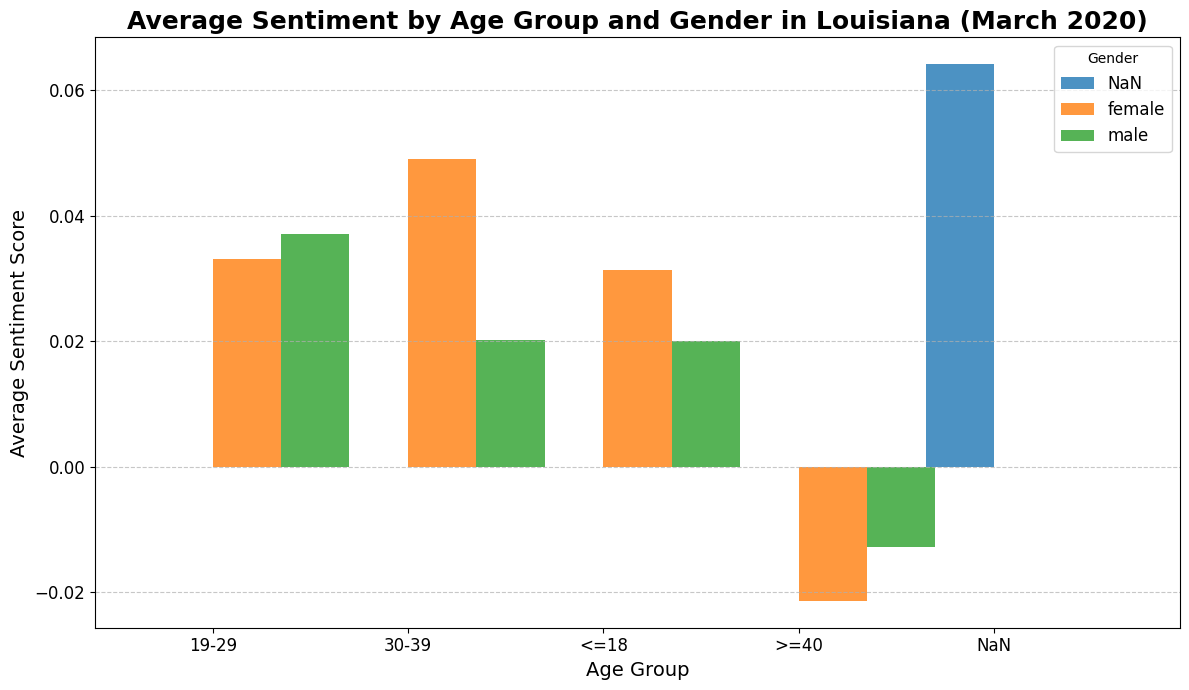

In [9]:
# Set the legacy time parser policy
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Set the Spark time zone to UTC
spark.conf.set("spark.sql.session.timeZone", "UTC")

# Convert Timestamp to timestamp type
spark_df = spark_df.withColumn("Timestamp", to_timestamp(col("Timestamp"), "EEE MMM dd HH:mm:ss Z yyyy"))

# Show the modified DataFrame with only the Timestamp column
spark_df.show(2, truncate=False)

# Now filter for tweets from Louisiana in March 2020
la_march_df = spark_df.filter(
    (spark_df.State == 'Louisiana') & 
    (spark_df.Timestamp >= '2020-03-01') & 
    (spark_df.Timestamp < '2020-04-01')
)

# Group by Age Group and Gender, calculate average sentiment, and sort the results
sentiment_by_age_gender_la = la_march_df.groupBy("AgeGroup", "Gender") \
    .agg(avg("Sentiment").alias("avg_sentiment")) \
    .orderBy("AgeGroup", "Gender")

# Collect the data from the Spark DataFrame
data_la = sentiment_by_age_gender_la.collect()

# Prepare data for plotting
age_groups = sorted(set(row.AgeGroup for row in data_la))
genders = sorted(set(row.Gender for row in data_la))

# Create a matrix to hold the average sentiments
avg_sentiment_matrix_la = {age_group: [] for age_group in age_groups}

for age_group in age_groups:
    for gender in genders:
        # Get the average sentiment for the specific age group and gender
        row = next((row for row in data_la if row.AgeGroup == age_group and row.Gender == gender), None)
        avg_sentiment_matrix_la[age_group].append(row.avg_sentiment if row else 0)

# Convert the matrix into a format suitable for plotting
bar_width = 0.35
x = range(len(age_groups))

# Create the bar plot
plt.figure(figsize=(12, 7))  # Increased figure size for better clarity

# Plot bars for each gender
for i, gender in enumerate(genders):
    plt.bar([p + i * bar_width for p in x], 
            [avg_sentiment_matrix_la[age_group][i] for age_group in age_groups], 
            width=bar_width, 
            label=gender, 
            alpha=0.8)  # Set transparency for better visibility

# Customizing the plot
plt.title("Average Sentiment by Age Group and Gender in Louisiana (March 2020)", fontsize=18, fontweight='bold')
plt.xlabel("Age Group", fontsize=14)
plt.ylabel("Average Sentiment Score", fontsize=14)
plt.xticks([p + bar_width / 2 for p in x], age_groups, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend
plt.legend(title='Gender', fontsize=12)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

+-------------------+------------------+------------+-------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+------+----+---------+-------------+--------+--------------+------+-----------------+--------------+-------+
|TweetID            |UserID            |Username    |Timestamp          |Text                                                                                                                                                                                                                                                                                 |State    |County|City|Sentiment|COVID-related|AgeGroup|Age_Confidence|Gender|Gender_Confidence|Org_Confidence|Retweet|
+-------------------+------------------+------------+-------

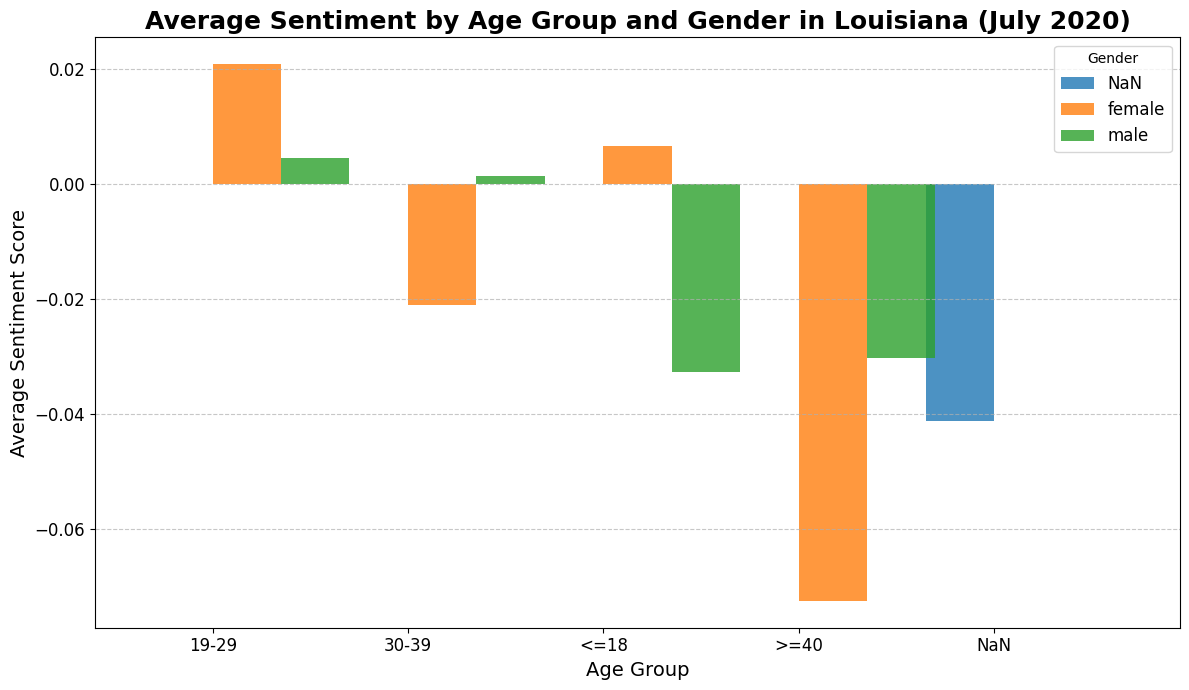

In [10]:
# Convert Timestamp to timestamp type
spark_df = spark_df.withColumn("Timestamp", to_timestamp(col("Timestamp"), "EEE MMM dd HH:mm:ss Z yyyy"))

# Show the modified DataFrame with only the Timestamp column
spark_df.show(2, truncate=False)

# Now filter for tweets from Louisiana in July 2020
la_july_df = spark_df.filter(
    (spark_df.State == 'Louisiana') & 
    (spark_df.Timestamp >= '2020-07-01') & 
    (spark_df.Timestamp < '2020-08-01')
)

# Group by Age Group and Gender, calculate average sentiment, and sort the results
sentiment_by_age_gender_la_july = la_july_df.groupBy("AgeGroup", "Gender") \
    .agg(avg("Sentiment").alias("avg_sentiment")) \
    .orderBy("AgeGroup", "Gender")

# Collect the data from the Spark DataFrame
data_la_july = sentiment_by_age_gender_la_july.collect()

# Prepare data for plotting
age_groups = sorted(set(row.AgeGroup for row in data_la_july))
genders = sorted(set(row.Gender for row in data_la_july))

# Create a matrix to hold the average sentiments
avg_sentiment_matrix_la_july = {age_group: [] for age_group in age_groups}

for age_group in age_groups:
    for gender in genders:
        # Get the average sentiment for the specific age group and gender
        row = next((row for row in data_la_july if row.AgeGroup == age_group and row.Gender == gender), None)
        avg_sentiment_matrix_la_july[age_group].append(row.avg_sentiment if row else 0)

# Convert the matrix into a format suitable for plotting
bar_width = 0.35
x = range(len(age_groups))

# Create the bar plot
plt.figure(figsize=(12, 7))  # Increased figure size for better clarity

# Plot bars for each gender
for i, gender in enumerate(genders):
    plt.bar([p + i * bar_width for p in x], 
            [avg_sentiment_matrix_la_july[age_group][i] for age_group in age_groups], 
            width=bar_width, 
            label=gender, 
            alpha=0.8)  # Set transparency for better visibility

# Customizing the plot
plt.title("Average Sentiment by Age Group and Gender in Louisiana (July 2020)", fontsize=18, fontweight='bold')
plt.xlabel("Age Group", fontsize=14)
plt.ylabel("Average Sentiment Score", fontsize=14)
plt.xticks([p + bar_width / 2 for p in x], age_groups, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend
plt.legend(title='Gender', fontsize=12)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


+-------------------+------------------+------------+-------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+------+----+---------+-------------+--------+--------------+------+-----------------+--------------+-------+
|TweetID            |UserID            |Username    |Timestamp          |Text                                                                                                                                                                                                                                                                                 |State    |County|City|Sentiment|COVID-related|AgeGroup|Age_Confidence|Gender|Gender_Confidence|Org_Confidence|Retweet|
+-------------------+------------------+------------+-------

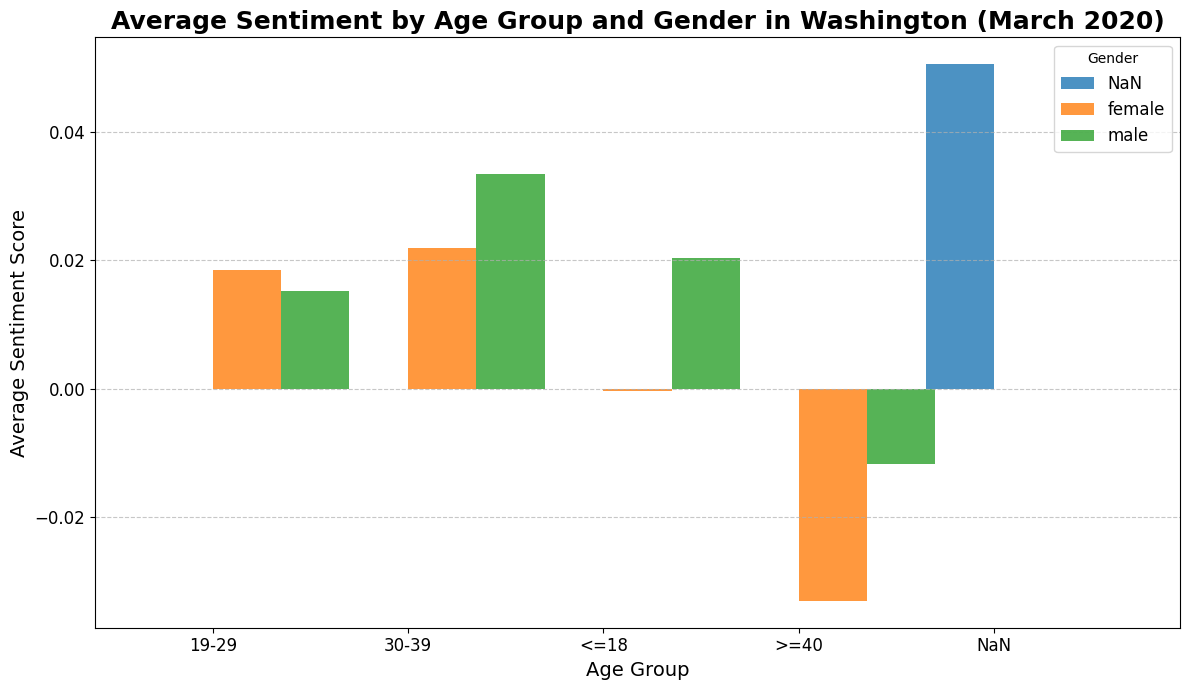

In [11]:
# Convert Timestamp to timestamp type
spark_df = spark_df.withColumn("Timestamp", to_timestamp(col("Timestamp"), "EEE MMM dd HH:mm:ss Z yyyy"))

# Show the modified DataFrame with only the Timestamp column
spark_df.show(2, truncate=False)

# Now filter for tweets from Washington in March 2020
wa_march_df = spark_df.filter(
    (spark_df.State == 'Washington') & 
    (spark_df.Timestamp >= '2020-03-01') & 
    (spark_df.Timestamp < '2020-04-01')
)

# Group by Age Group and Gender, calculate average sentiment, and sort the results
sentiment_by_age_gender_wa_march = wa_march_df.groupBy("AgeGroup", "Gender") \
    .agg(avg("Sentiment").alias("avg_sentiment")) \
    .orderBy("AgeGroup", "Gender")

# Collect the data from the Spark DataFrame
data_wa_march = sentiment_by_age_gender_wa_march.collect()

# Prepare data for plotting
age_groups = sorted(set(row.AgeGroup for row in data_wa_march))
genders = sorted(set(row.Gender for row in data_wa_march))

# Create a matrix to hold the average sentiments
avg_sentiment_matrix_wa_march = {age_group: [] for age_group in age_groups}

for age_group in age_groups:
    for gender in genders:
        # Get the average sentiment for the specific age group and gender
        row = next((row for row in data_wa_march if row.AgeGroup == age_group and row.Gender == gender), None)
        avg_sentiment_matrix_wa_march[age_group].append(row.avg_sentiment if row else 0)

# Convert the matrix into a format suitable for plotting
bar_width = 0.35
x = range(len(age_groups))

# Create the bar plot
plt.figure(figsize=(12, 7))  # Increased figure size for better clarity

# Plot bars for each gender
for i, gender in enumerate(genders):
    plt.bar([p + i * bar_width for p in x], 
            [avg_sentiment_matrix_wa_march[age_group][i] for age_group in age_groups], 
            width=bar_width, 
            label=gender, 
            alpha=0.8)  # Set transparency for better visibility

# Customizing the plot
plt.title("Average Sentiment by Age Group and Gender in Washington (March 2020)", fontsize=18, fontweight='bold')
plt.xlabel("Age Group", fontsize=14)
plt.ylabel("Average Sentiment Score", fontsize=14)
plt.xticks([p + bar_width / 2 for p in x], age_groups, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend
plt.legend(title='Gender', fontsize=12)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


+-------------------+------------------+------------+-------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+------+----+---------+-------------+--------+--------------+------+-----------------+--------------+-------+
|TweetID            |UserID            |Username    |Timestamp          |Text                                                                                                                                                                                                                                                                                 |State    |County|City|Sentiment|COVID-related|AgeGroup|Age_Confidence|Gender|Gender_Confidence|Org_Confidence|Retweet|
+-------------------+------------------+------------+-------

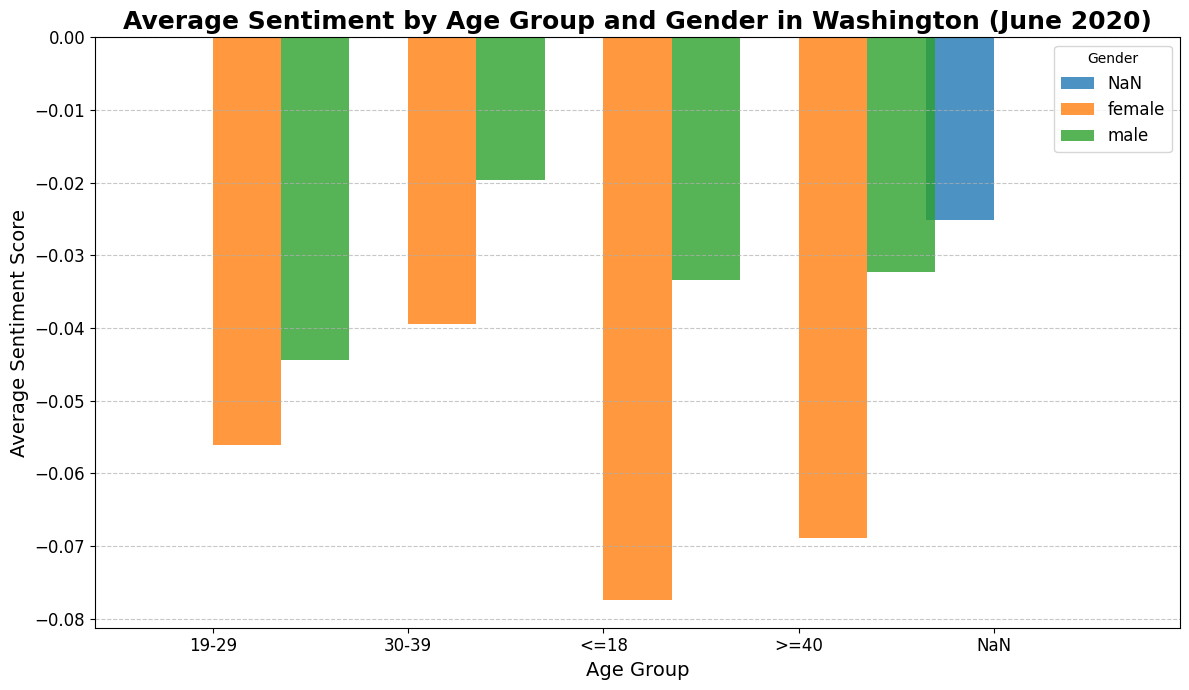

In [12]:
# Convert Timestamp to timestamp type
spark_df = spark_df.withColumn("Timestamp", to_timestamp(col("Timestamp"), "EEE MMM dd HH:mm:ss Z yyyy"))

# Show the modified DataFrame with only the Timestamp column
spark_df.show(2, truncate=False)

# Now filter for tweets from Washington in June 2020
wa_june_df = spark_df.filter(
    (spark_df.State == 'Washington') & 
    (spark_df.Timestamp >= '2020-06-01') & 
    (spark_df.Timestamp < '2020-07-01')
)

# Group by Age Group and Gender, calculate average sentiment, and sort the results
sentiment_by_age_gender_wa_june = wa_june_df.groupBy("AgeGroup", "Gender") \
    .agg(avg("Sentiment").alias("avg_sentiment")) \
    .orderBy("AgeGroup", "Gender")

# Collect the data from the Spark DataFrame
data_wa_june = sentiment_by_age_gender_wa_june.collect()

# Prepare data for plotting
age_groups = sorted(set(row.AgeGroup for row in data_wa_june))
genders = sorted(set(row.Gender for row in data_wa_june))

# Create a matrix to hold the average sentiments
avg_sentiment_matrix_wa_june = {age_group: [] for age_group in age_groups}

for age_group in age_groups:
    for gender in genders:
        # Get the average sentiment for the specific age group and gender
        row = next((row for row in data_wa_june if row.AgeGroup == age_group and row.Gender == gender), None)
        avg_sentiment_matrix_wa_june[age_group].append(row.avg_sentiment if row else 0)

# Convert the matrix into a format suitable for plotting
bar_width = 0.35
x = range(len(age_groups))

# Create the bar plot
plt.figure(figsize=(12, 7))  # Increased figure size for better clarity

# Plot bars for each gender
for i, gender in enumerate(genders):
    plt.bar([p + i * bar_width for p in x], 
            [avg_sentiment_matrix_wa_june[age_group][i] for age_group in age_groups], 
            width=bar_width, 
            label=gender, 
            alpha=0.8)  # Set transparency for better visibility

# Customizing the plot
plt.title("Average Sentiment by Age Group and Gender in Washington (June 2020)", fontsize=18, fontweight='bold')
plt.xlabel("Age Group", fontsize=14)
plt.ylabel("Average Sentiment Score", fontsize=14)
plt.xticks([p + bar_width / 2 for p in x], age_groups, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend
plt.legend(title='Gender', fontsize=12)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [18]:
import nbformat

# Load the notebook file
with open('sentiment_analysis.ipynb', 'r', encoding='utf-8') as f:
    notebook = nbformat.read(f, as_version=4)

# Count the lines of code in all code cells
code_lines = 0
for cell in notebook['cells']:
    if cell['cell_type'] == 'code':
        code_lines += len(cell['source'].splitlines())

print(f"Total lines of code: {code_lines}")


Total lines of code: 477


In [19]:
import json

def count_spark_operations(notebook_path):
    # Open the notebook file with utf-8 encoding
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = json.load(f)

    spark_operation_count = 0
    for cell in notebook['cells']:
        if cell['cell_type'] == 'code':
            code = cell['source']
            # Check for common Spark operation keywords
            for line in code:
                if any(op in line for op in ['filter', 'select', 'groupBy', 'join', 'map', 'reduce', 'show', 'collect']):
                    spark_operation_count += 1

    return spark_operation_count

# Example usage
notebook_path = 'sentiment_analysis.ipynb'  # Update this with your notebook path
operation_count = count_spark_operations(notebook_path)
print(f"Number of Spark Operations Found: {operation_count}")


Number of Spark Operations Found: 42
